# Scattering from a sphere using a direct formulation

## The problem

In this tutorial, we will solve the problem of scattering from the unit sphere $\Omega$ with an incident wave defined by

$$
u^{\text{inc}}(\mathbf x) = \mathrm{e}^{\mathrm{i} k x_0}.
$$

where $\mathbf x = (x_0, x_1, x_2)$.

Acoustic waves are governed by the Helmholtz equation:

$$
\Delta u + k^2 u = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega,
$$

where $u=u^\text{tot}=u^\text{s}+u^\text{inc}$ is the total acoustic field and $u^\text{s}$ satisfies the Sommerfeld radiation condition

$$
\frac{\partial u^\text{s}}{\partial r}-\mathrm{i}ku^\text{s}=o(r^{-1})
$$

for $r:=|\mathbf{x}|\rightarrow\infty$.

For our problem, we impose a Neumann boundary condition:

$$
\frac{\partial u}{\partial\nu}=0, \quad \text{ on } \Gamma,
$$

where $\Gamma$ is the surface of the sphere $\Omega$, and $\nu$ is the normal to the surface $\Gamma$ (pointing outwards).

## Representation formula

It can be shown that the (unknown) scattered field in our problem can be represented as

$$
u^\text{s} = \int_\Gamma \frac{\partial G(\mathbf x, \mathbf y)}{\partial \nu(\mathbf y)}u_\text{D}(\mathbf y)\,\mathrm{d}\mathbf{y} -\int_\Gamma G(\mathbf x, \mathbf y)\lambda(\mathbf y)\,\mathrm{d}\mathbf{y},
$$

where $u_\text{D}$ is the trace of $u^\text{s}$ on $\Gamma$; $\lambda$ is the normal derivative of $u^\text{s}$ on $\Gamma$; and $G(\mathbf x, \mathbf y)$ is the acoustic Green's function given by

$$
G(\mathbf x, \mathbf y):=\frac{\mathrm{e}^{\mathrm{i} k |\mathbf{x}-\mathbf{y}|}}{4 \pi |\mathbf{x}-\mathbf{y}|}.
$$

As we are solving a Neumann problem, $\lambda$ is given by the boundary conditions. In order for the normal derivative of the total field to be 0 on $\Gamma$, we see that

$$\lambda = \frac{\partial u^\text{s}}{\partial\nu} = -\frac{\partial u^\text{inc}}{\partial\nu}.$$

Using the single layer ($\mathcal{V}$) and double layer ($\mathcal{K}$) potential operators, this can be rewritten as

$$
u^\text{s} = \mathcal{K}u_\text{D} -\mathcal{V}\lambda.
$$

## Boundary integral equation

Taking the trace of the representation formula, we can derive a boundary integral equation. Using the single layer ($\mathsf{V}$), double layer ($\mathsf{K}$) and identity ($\mathsf{Id}$) boundary operators, this can be written as

$$
(\mathsf{K} - \tfrac12\mathsf{Id})u_\text{D} = \mathsf{V}\lambda.
$$

We will solve a discretisation of the equation to find (an approximation of) $u_\text{D}$. This can then be used with the representation formula to evaluate $u^\text{tot}$ at various points outside the sphere.

## Solving with Bempp

We start by importing Bempp and other libraries we will use.

In [1]:
import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

We set the wavenumber we will use (15), create the discretised sphere, and define a space of piecewise constant functions.

In [2]:
k = 15.

grid = bempp.api.shapes.regular_sphere(3)

space = bempp.api.function_space(grid, "DP", 0)

We define the identity ($\mathsf{Id}$), single layer ($\mathsf{V}$) and double layer ($\mathsf{K}$) boundary operators. Each operator is given three spaces as inputs: the domain, range, and dual spaces (in that order).

In this example, all three spaces are the same. In more complex examples, this will not alwasy be the best choice and spaces must be chosen carefully. The single and double layer operators also take the wavenumber as an input.

In [3]:
identity = sparse.identity(space, space, space)
double_layer = helmholtz.double_layer(space, space, space, k)
single_layer = helmholtz.single_layer(space, space, space, k)

We define the Neumann boundary data $\lambda-\frac{\partial u^\text{inc}}{\partial\nu}$. We use $u^{\text{inc}}(\mathbf x) = \mathrm{e}^{\mathrm{i} k x_0}$, and so the boundary data is $\mathrm{i}k\nu_0\mathrm{e}^{\mathrm{i} k x_0}$, where $\nu=(\nu_0,\nu_1,\nu_2)$.

A `GridFunction` object is Bempp's representation of a function in a discrete space. We wrap the function as a `complex_callable`. This is so that Numba knows how to use just-in-time compilation correctly to speed up the creation of the `GridFunction`.

In [4]:
@bempp.api.complex_callable
def lambda_inc(x, n, domain_index, result):
    result[0] = -1j * k * np.exp(1j * k * x[0]) * n[0]


lambda_fun = bempp.api.GridFunction(space, fun=lambda_inc)

We now define the left and right hand sides of the equation

$$
(\mathsf{K} - \tfrac12\mathsf{Id})u_\text{D} = \mathsf{V}\lambda.
$$

In [5]:
lhs = double_layer - 0.5 * identity
rhs = single_layer * lambda_fun

/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


We now use GMRES linear solver to solve the matrix system.

Internally, Bempp will create the matrix discretisations of the boundary operators during this step, and use Scipy's GMRES solver.

In [12]:
u_d, info = gmres(lhs, rhs, tol=1E-5)

We now plot a some 2D slices through the solution. First, we use Numpy to create a grid of points to evaluate the solution at.

In [7]:
Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

First, we plot the incident wave $u^\text{inc}$.

The magic command `mathplotlib inline` allows matplotlib to display plots inside Jupyter notebooks. This command should be removed if running this outside a notebook.

Text(0.5, 1.0, 'Incident wave in the plane z=0')

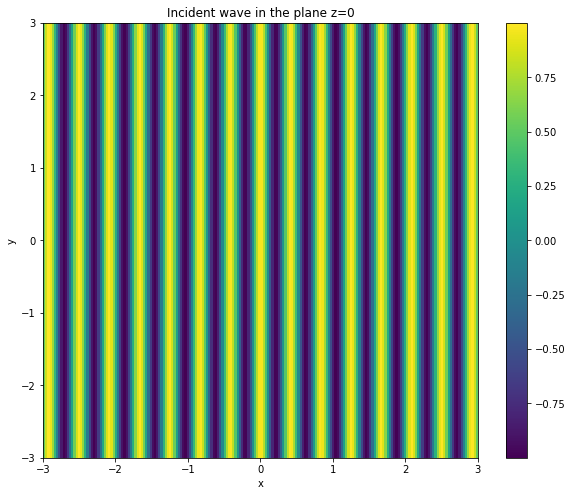

In [8]:
%matplotlib inline

u_inc = np.real(np.exp(1j * k * points[0, :]))
u_inc = u_inc.reshape((Nx, Ny))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(u_inc.T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Incident wave in the plane z=0")

Next, we plot the scattered wave, $u^\text{s}$. This is computed using the equation

$$
u^\text{s} = \mathcal{K}u_\text{D} -\mathcal{V}\lambda.
$$


/usr/lib/python3/dist-packages/pytools/persistent_dict.py:506: UserWarning: pytools.persistent_dict.WriteOncePersistentDict(pyopencl-invoker-cache-v6) encountered an invalid key file for key f95f2d5f1af67b2162dcd2820e940bc49311eccdc795d8e43f68b317adcef9f3. Remove the directory '/home/mscroggs/.cache/pytools/pdict-v2-pyopencl-invoker-cache-v6-py3.8.5.final.0/f95f2d5f1af67b2162dcd2820e940bc49311eccdc795d8e43f68b317adcef9f3' if necessary. (caught: EOFError: Ran out of input)
  return self.fetch(key, _stacklevel=1)
/usr/lib/python3/dist-packages/pytools/persistent_dict.py:506: UserWarning: pytools.persistent_dict.WriteOncePersistentDict(pyopencl-invoker-cache-v6) encountered an invalid key file for key 45f65aeff63e7a71eb3e198d8004bd8598eb2a10cdb1cd9c6eb5a711cdac3d6f. Remove the directory '/home/mscroggs/.cache/pytools/pdict-v2-pyopencl-invoker-cache-v6-py3.8.5.final.0/45f65aeff63e7a71eb3e198d8004bd8598eb2a10cdb1cd9c6eb5a711cdac3d6f' if necessary. (caught: EOFError: Ran out of input)
  retu

Text(0.5, 1.0, 'Scattered wave in the plane z=0')

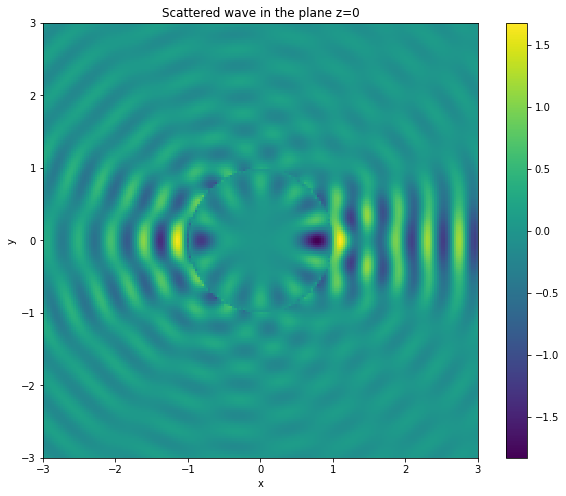

In [9]:
%matplotlib inline

single_pot = helmholtz_potential.single_layer(space, points, k)
double_pot = helmholtz_potential.double_layer(space, points, k)
u_s = np.real(double_pot.evaluate(u_d) - single_pot.evaluate(lambda_fun))

u_s = u_s.reshape((Nx, Ny))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(u_s.T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Scattered wave in the plane z=0")

Finally, we plot $u^\text{tot}=u^\text{inc} + u^\text{s}$.

Text(0.5, 1.0, 'Total wave in the plane z=0')

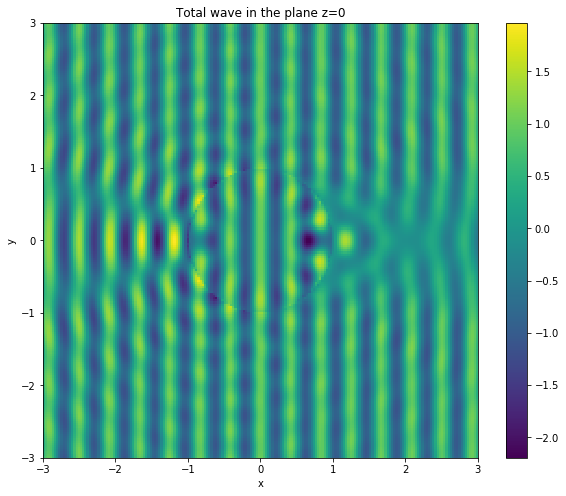

In [10]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real((u_inc + u_s).T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")

Using some (slightly ugly) functionality of Numpy, we can hide the solution inside the sphere.

Text(0.5, 1.0, 'Total wave in the plane z=0')

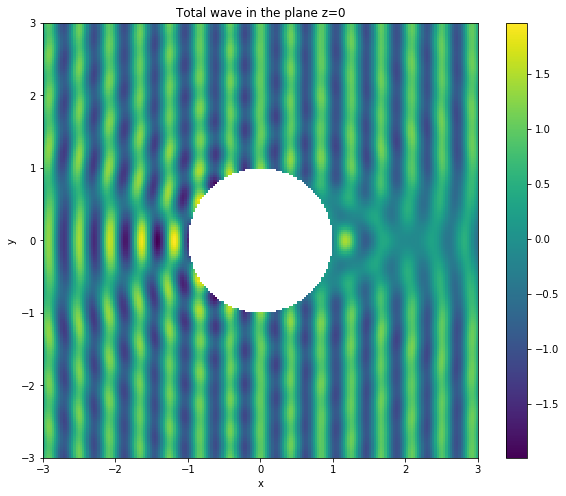

In [11]:
%matplotlib inline

x, y, z = points
idx = np.sqrt(x**2 + y**2) > 1.0

single_pot = helmholtz_potential.single_layer(space, points[:, idx], k)
double_pot = helmholtz_potential.double_layer(space, points[:, idx], k)

u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
u_evaluated[:] = np.nan
u_evaluated[idx] = np.real(np.exp(1j * k * points[0, idx])
                           + double_pot.evaluate(u_d)
                           - single_pot.evaluate(lambda_fun)).flat
u_evaluated = u_evaluated.reshape((Nx, Ny))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(u_evaluated.T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")